<a href="https://colab.research.google.com/github/RockhoRockho/Deep_Learning/blob/main/_10_3_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8_%EB%AA%A8%EB%8D%B8_%EC%82%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [5]:
!wget http://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

--2021-12-17 05:24:05--  http://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.239.174.62, 54.239.174.14, 54.239.174.95, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.239.174.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   110MB/s    in 0.4s    

2021-12-17 05:24:06 (110 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./hymenoptera_data/
   creating: ./hymenoptera_data/train/
   creating: ./hymenoptera_data/train/ants/
  inflating: ./hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: 

## 전처리 설정

In [6]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [7]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [9]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [11]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [13]:
exp_lr_scheduler =lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs =model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss =criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss = loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase =='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Acurracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0136	Accuracy: 0.6189
val Loss: 0.0000	Accuracy: 0.8366

Epoch 1/24
----------
train Loss: 0.0123	Accuracy: 0.7951
val Loss: 0.0002	Accuracy: 0.8627

Epoch 2/24
----------
train Loss: 0.0091	Accuracy: 0.7910
val Loss: 0.0000	Accuracy: 0.7908

Epoch 3/24
----------
train Loss: 0.0010	Accuracy: 0.7951
val Loss: 0.0000	Accuracy: 0.8562

Epoch 4/24
----------
train Loss: 0.0025	Accuracy: 0.8115
val Loss: 0.0000	Accuracy: 0.8497

Epoch 5/24
----------
train Loss: 0.0004	Accuracy: 0.8197
val Loss: 0.0000	Accuracy: 0.8170

Epoch 6/24
----------
train Loss: 0.0042	Accuracy: 0.8443
val Loss: 0.0022	Accuracy: 0.7843

Epoch 7/24
----------
train Loss: 0.0010	Accuracy: 0.8770
val Loss: 0.0000	Accuracy: 0.9150

Epoch 8/24
----------
train Loss: 0.0042	Accuracy: 0.8852
val Loss: 0.0003	Accuracy: 0.9150

Epoch 9/24
----------
train Loss: 0.0031	Accuracy: 0.8402
val Loss: 0.0000	Accuracy: 0.9150

Epoch 10/24
----------
train Loss: 0.0024	Accuracy: 0.8402
val Loss: 0.0000	Accuracy: 0.8954

## 결과 시각화

- 시각화 함수 정의

In [25]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


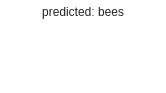

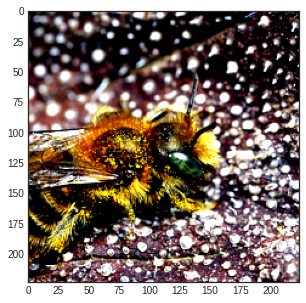

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


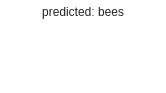

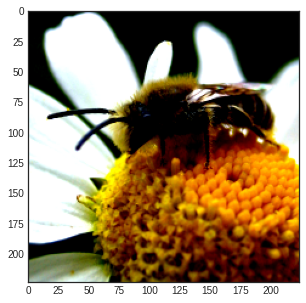

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


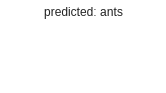

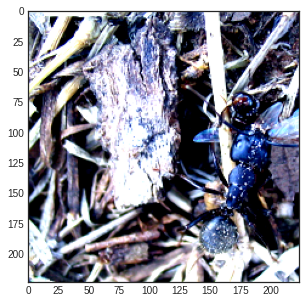

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


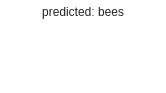

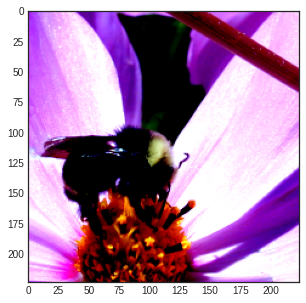

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


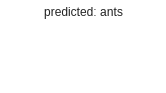

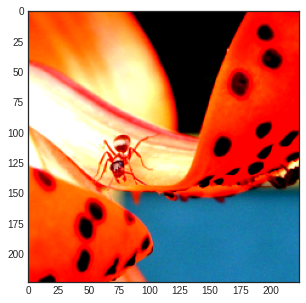

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


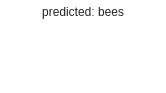

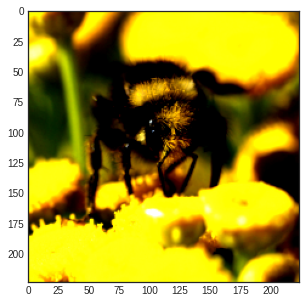

In [31]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0038	Accuracy: 0.7049
val Loss: 0.0000	Accuracy: 0.8758

Epoch 1/24
----------
train Loss: 0.0015	Accuracy: 0.7418
val Loss: 0.0010	Accuracy: 0.9216

Epoch 2/24
----------
train Loss: 0.0052	Accuracy: 0.7623
val Loss: 0.0001	Accuracy: 0.8954

Epoch 3/24
----------
train Loss: 0.0064	Accuracy: 0.8156
val Loss: 0.0000	Accuracy: 0.9542

Epoch 4/24
----------
train Loss: 0.0354	Accuracy: 0.8197
val Loss: 0.0001	Accuracy: 0.8954

Epoch 5/24
----------
train Loss: 0.0027	Accuracy: 0.8074
val Loss: 0.0000	Accuracy: 0.9477

Epoch 6/24
----------
train Loss: 0.0197	Accuracy: 0.8361
val Loss: 0.0297	Accuracy: 0.9150

Epoch 7/24
----------
train Loss: 0.0008	Accuracy: 0.8852
val Loss: 0.0001	Accuracy: 0.9412

Epoch 8/24
----------
train Loss: 0.0177	Accuracy: 0.8689
val Loss: 0.0000	Accuracy: 0.9477

Epoch 9/24
----------
train Loss: 0.0005	Accuracy: 0.8361
val Loss: 0.0000	Accuracy: 0.9542

Epoch 10/24
----------
train Loss: 0.0022	Accuracy: 0.8607
val Loss: 0.0000	Accuracy: 0.9542

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


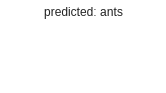

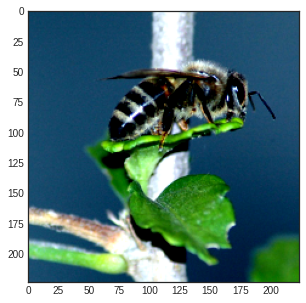

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


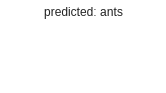

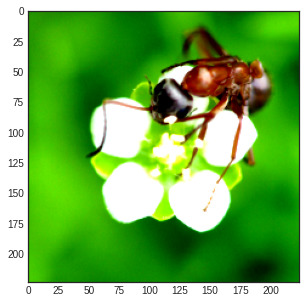

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


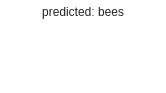

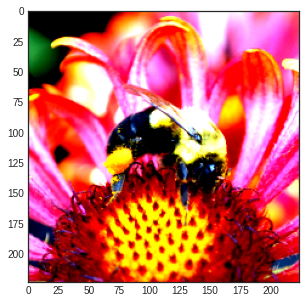

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


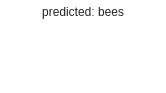

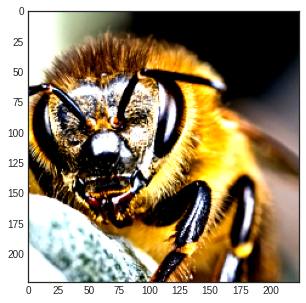

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


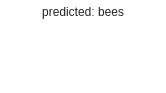

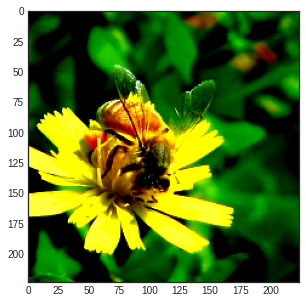

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


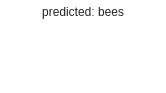

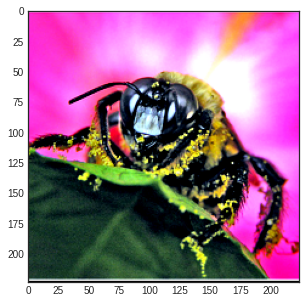

In [34]:
visualize_model(model_conv)